In [1]:
# import suite2p
import matplotlib.pyplot as plt
import h5py
import suite2p
import re
import datetime
import numpy as np
from skimage.transform import resize
from skimage import draw
from skimage.segmentation import find_boundaries
from skimage.filters import gaussian as gaussfilt

from matplotlib.colors import LinearSegmentedColormap
from sklearn.decomposition import FastICA

import matplotlib.animation as animation
from scipy.spatial.distance import squareform

In [2]:
raw = "C:\\Users\\zfj\\data\\081122B\\func\\region4_00001.tif"
reg = "C:\\Users\\zfj\\data\\081122B\\func\\suite2p\\plane0\\reg_tif_chan2\\file{:03d}_chan1.tif"
bing = "C:\\Users\\zfj\\data\\081122B\\func\\suite2p\\plane0\\data.bin"
binr = "C:\\Users\\zfj\\data\\081122B\\func\\suite2p\\plane0\\data_chan2.bin"
timing = "C:\\Users\\zfj\\data\\081122B\\081122B.h5"
mask = "C:\\Users\\zfj\\data\\training\\081122B_region4_67_masks.tif"

In [3]:
tif = suite2p.io.tiff.ScanImageTiffReader(raw)

In [4]:
dotnet_epoch = datetime.datetime(1, 1, 1)
us = datetime.timedelta(microseconds = 1)

a = re.search("epoch = \[((?:\d+.?\d+,?)+)\]", tif.description(0))
t = [float(x) for x in a.groups()[0].split(',')]
t.append(t[-1] % 1 * 1e6)
t = [int(ti) for ti in t]
offset = 10 * (datetime.datetime(*t) - dotnet_epoch) // us 

ts = np.empty((len(tif)//4), dtype=np.int64)

for i in np.arange(0, len(tif), 4):
    a = re.search("frameTimestamps_sec = (\d+.?\d+)", tif.description(i))
    ts[i//4] = float(a.groups()[0]) * 1e7 + offset

# .NET to datetime: datetime.datetime(1, 1, 1) + datetime.timedelta(microseconds = ticks//10)


In [5]:
stim_file = h5py.File(timing,"r")
epochs = {
    'start_times':[],
    'cx': [],
    'cy': [],
}
# epoch_blocks.append({**g['protocolParameters'].attrs, 'epochs':epochs})
dotNetOffset = 1e6*60*60 #ticks per hour
def append_epochs(name, g):
    if 'protocolID' in g.attrs and g.attrs['protocolID'] == b'sa_labs.protocols.stage.multiSMS.HexSMS':   
        # print({**g['protocolParameters'].attrs})
        for epoch in g['epochs']:
            # print((g['epochs'][epoch].attrs['startTimeDotNetDateTimeOffsetOffsetHours'],g['epochs'][epoch].attrs['startTimeDotNetDateTimeOffsetTicks']))
            # return
            epochs['start_times'].append(g['epochs'][epoch].attrs['startTimeDotNetDateTimeOffsetTicks'])# - (g['epochs'][epoch].attrs['startTimeDotNetDateTimeOffsetOffsetHours']*dotNetOffset))
            # epochs['start_times'].append(g['epochs'][epoch].attrs['startTimeDotNetDateTimeOffsetTicks'])
            epochs['cx'].append(g['epochs'][epoch]['protocolParameters'].attrs['cx'])
            epochs['cy'].append(g['epochs'][epoch]['protocolParameters'].attrs['cy'])
stim_file.visititems(append_epochs)

# plt.scatter(epochs['cx'],epochs['cy'])


In [6]:
trigger = tif.data().reshape(-1,4,32,128)[:,3,:,:]
trigger[:,1::,:] = np.flip(trigger[:,1::,:], axis=2)
trigger = trigger.flatten()
td =  trigger[2:] - trigger[:-2]
trigs = np.argwhere(td > 15000)

ntrigs = np.argwhere(td < -15000)
print(trigs.shape)

(3548, 1)


(1778,)
(1268,)
6645886 6957025


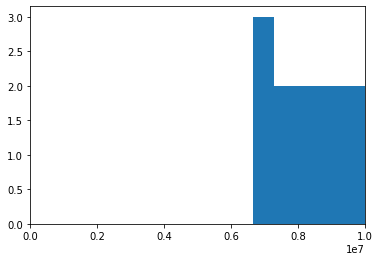

In [7]:
# trigger[trigs[0]-1000]
trigs = np.delete(trigs, np.argwhere(trigs[1:] - trigs[:-1] < 200)+1)
print(trigs.shape)
T= trigs[:,None] - ntrigs[:,None].T

trigs = np.delete(trigs, np.argwhere(np.logical_and(T < 200, T >= 0).squeeze())[:,0])
print(trigs.shape)

print(trigs[0],trigs[1])
plt.hist(trigs,1000)
plt.xlim(0,1e7)
plt.show()


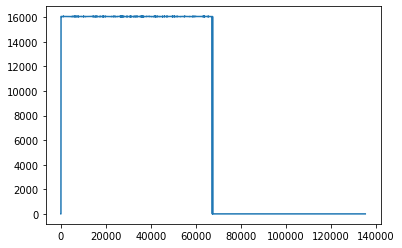

In [185]:

plt.plot(trigger[trigs[0]-10 : trigs[0]+32*128*33])

(1756,)
(1268,)
6713086 7024126


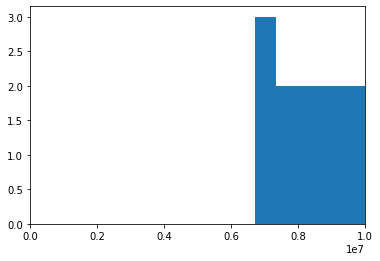

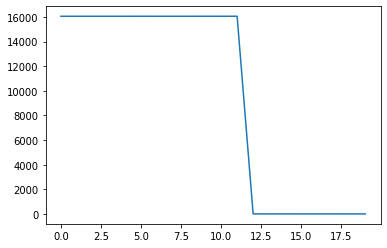

In [8]:
# trigger[trigs[0]-1000]
ntrigs = np.delete(ntrigs, np.argwhere(ntrigs[1:] - ntrigs[:-1] < 200)+1)
print(ntrigs.shape)
T= ntrigs[:,None] - trigs[:,None].T

ntrigs = np.delete(ntrigs, np.argwhere(np.logical_and(T < 200, T >= 0).squeeze())[:,0])
print(ntrigs.shape)

print(ntrigs[0],ntrigs[1])
plt.hist(ntrigs,1000)
plt.xlim(0,1e7)
plt.show()

plt.plot(trigger[ntrigs[0]-10 : ntrigs[0]+10])

In [187]:
ts[trigs // (32*128)]

array([637958402887125120, 637958402910302080, 637958402931649280, ...,
       637958449187677184, 637958449559423360, 637958449932694400],
      dtype=int64)

In [9]:
# idx = np.abs(np.expand_dims(epochs['start_times'],axis=0) - np.expand_dims(ts[trigs // (32*128)],axis=1)).argmin(axis=0)
# # idx_missing = np.union1d(np.where(idx==len(ts)-1), np.where(idx==0))
# # epochs['start_times'] = np.delete(epochs['start_times'], idx_missing)
# # epochs['cx'] = np.delete(epochs['cx'], idx_missing)
# # epochs['cy'] = np.delete(epochs['cy'], idx_missing)
# # idx = np.delete(idx, idx_missing)
time_delta = np.abs(np.expand_dims(epochs['start_times'],axis=0) - np.expand_dims(ts[trigs // (32*128)],axis=1))
idx_e = time_delta.argmin(axis=0)
idx_i = time_delta.argmin(axis=1)

idx_i_missing = np.array(np.nonzero(np.take_along_axis(time_delta, np.expand_dims(idx_i, axis=1), axis=1) > 1e7))[0]
idx_i = np.delete(idx_i, idx_i_missing)

idx_e_missing = np.array(np.nonzero(np.take_along_axis(time_delta, np.expand_dims(idx_e, axis=0), axis=0) > 1e7))[1]
idx_e = np.delete(idx_e, idx_e_missing)
idx_e_idx = idx_e.argsort()

for k in epochs:
    epochs[k] = np.delete(epochs[k], idx_e_missing)
    epochs[k] = epochs[k][idx_e_idx] #sort the trials by start time

trigs= np.delete(trigs, idx_i_missing)



# idx = np.abs(np.expand_dims(epochs['start_times'],axis=0) - np.expand_dims(ts,axis=1)).argmin(axis=0)
# idx_missing = np.union1d(np.where(idx==len(ts)-1), np.where(idx==0))
# epochs['start_times'] = np.delete(epochs['start_times'], idx_missing)
# epochs['cx'] = np.delete(epochs['cx'], idx_missing)
# epochs['cy'] = np.delete(epochs['cy'], idx_missing)
# idx = np.delete(idx, idx_missing)


In [189]:
print(len(trigs), len(epochs['start_times']))

1222 1222


In [136]:
print(tif.metadata())

SI.LINE_FORMAT_VERSION = 1
SI.TIFF_FORMAT_VERSION = 4
SI.VERSION_COMMIT = '306db24f7aaaf13afde17cbc3522447082dff778'
SI.VERSION_MAJOR = '5.7'
SI.VERSION_MINOR = '1'
SI.acqState = 'grab'
SI.acqsPerLoop = 1
SI.extTrigEnable = false
SI.hBeams.beamCalibratedStatus = [true false]
SI.hBeams.directMode = [false false]
SI.hBeams.enablePowerBox = false
SI.hBeams.extPowerScaleFnc = []
SI.hBeams.flybackBlanking = true
SI.hBeams.interlaceDecimation = [1 1]
SI.hBeams.interlaceOffset = [0 0]
SI.hBeams.lengthConstants = [Inf Inf]
SI.hBeams.powerBoxEndFrame = Inf
SI.hBeams.powerBoxStartFrame = 1
SI.hBeams.powerBoxes.rect = [0.25 0.25 0.5 0.5]
SI.hBeams.powerBoxes.powers = [NaN NaN]
SI.hBeams.powerBoxes.name = ''
SI.hBeams.powerBoxes.oddLines = true
SI.hBeams.powerBoxes.evenLines = true
SI.hBeams.powerLimits = [100 100]
SI.hBeams.powers = [5 100]
SI.hBeams.pzAdjust = [false false]
SI.hBeams.pzCustom = {[] []}
SI.hBeams.tfExtForceStreaming = 0
SI.hChannels.channelAdcResolution = {16 16 16 16}
SI.hChanne

In [10]:
ue, e_i, e_c = np.unique(np.stack((epochs['cx'],epochs['cy'])),axis=1, return_inverse=True, return_counts=True)


In [12]:
print(ue)
print(e_c)

[[-24.74181249 -24.74181249 -16.49454166 -16.49454166 -16.49454166
   -8.24727083  -8.24727083   0.           0.           0.
    8.24727083   8.24727083  16.49454166  16.49454166  16.49454166
   24.74181249  24.74181249]
 [-14.2846921   14.2846921  -28.56938421   0.          28.56938421
  -14.2846921   14.2846921  -28.56938421   0.          28.56938421
  -14.2846921   14.2846921  -28.56938421   0.          28.56938421
  -14.2846921   14.2846921 ]]
[72 72 72 72 72 72 72 71 72 72 72 72 72 72 72 72 71]


In [ ]:
import util.preprocess

rois = util.preprocess.segment(
    r"C:\Users\zfj\data\081122B\func",
    {
        'frame_shape':(32,128),
        'n_channels':4,
        'pixel_rate':1 / 6.4e-06,
        'line_rate': 1 / 0.0009216,
        'frame_rate': 32.7912,
    },
    np.stack((trigs-33505,trigs,trigs+134018)), 
    e_i,
    r"C:\Users\zfj\data\training\081122B_region4_67_masks.tif", 
    r"C:\Users\zfj\data\101222B\dark_level_4.4p_00001.tif"
)


In [193]:
ue, e_i, e_c = np.unique(np.stack((epochs['cx'],epochs['cy'])),axis=1, return_inverse=True, return_counts=True)

print(e_i.max())

16


In [194]:
rois[0].roi
np.save(os.path.join(r"C:\Users\zfj\data\081122B\func", 'spots.npy'), np.asarray(rois, dtype=object))

In [196]:
print(",".join([f"{int(r.roi)}" for r in rois]))

1,2,3,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171


In [195]:
np.save(os.path.join(r"C:\Users\zfj\data\081122B\func",'spots_labels.npy'), e_i)


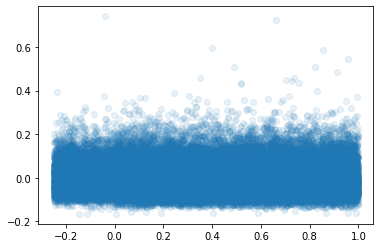

In [160]:
ri = 5
plt.scatter(rois[ri]['trial_t'], rois[ri]['dFoF'], alpha=.1)

In [7]:
frame_i = np.expand_dims(idx,axis=0) + np.expand_dims(np.arange(0,44),axis=1)
print(idx.shape, frame_i.shape)

# np.stack((epochs['cx'],epochs['cy'])).shape
ue, e_i, e_c = np.unique(np.stack((epochs['cx'],epochs['cy'])),axis=1, return_inverse=True, return_counts=True)
print(e_i.shape, ue.shape)

(1222,) (44, 1222)
(1222,) (2, 17)


In [ ]:
m = suite2p.io.tiff.open_tiff(mask, True)[0].pages[0].asarray()

def segment_ds(path):
    data = suite2p.io.BinaryRWFile(32, 128, path).data[frame_i.flatten()]
    act = np.empty((len(data),int(m.max())))
    # m_ds = resize(m, (32,128)).reshape((1,32,128)).repeat(len(data), 0)
    for i in range(int(m.max())):
        m_i = resize((m==i+1).astype(np.float64), (32,128), anti_aliasing=True)
        m_i /= m_i.sum()
        m_i = m_i.reshape((1,32,128)).repeat(len(data), 0)

        act[:,i] = (m_i * data).mean(axis=(1,2))
    
    return act.reshape((*frame_i.shape, -1))

g = segment_ds(bing)
gr = g / segment_ds(binr)

# plt.imshow(resize((m==1).astype(np.float64), (32,128), anti_aliasing=True))

# [resize(x, (32,128), anti_aliasing=True) for x in suite2p.io.BinaryRWFile(32, 128, bing).data[frame_i]]

# r = suite2p.io.BinaryRWFile(32, 128, bing)[frame_i] #should be registered?

# e = np.ma.masked_where(m[0].pages[0].asarray() == 1, g.data[frame_i])
# e = (e - e[:10].mean(axis=0)) / e[:10].mean(axis=0)

In [ ]:
# plt.imshow(g[:,:,147], aspect=40)
# plt.plot(suite2p.io.BinaryRWFile(32, 128, bing).data[:,15,92])
# plt.vlines(idx,0, 5000, color='k')

print(gr.shape)
fig,ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(((g-g[:10].mean(axis=0))/g[:10].mean(axis=0)).mean(axis=1))
ax[1].plot(gr.mean(axis=1))
ax[1].set_ylim(0,.2)

# plt.imshow(((g-g[:10].mean(axis=0))/g[:10].mean(axis=0))[:,:,95].T, aspect=1/40)
# plt.imshow(g[:,:,95].T, aspect=1/40)
# plt.imshow(gr[:,:,95].T, aspect=1/40)

# plt.colorbar()
# plt.plot(gr.mean(axis=1))
# plt.ylim((0,.1))

plt.show()

In [ ]:
epochs['dFoF_mean']=np.empty((g.shape[2], ue.shape[1], 44))
epochs['gr_mean']=np.empty((g.shape[2], ue.shape[1], 44))
epochs['dFoF_std']=np.empty((g.shape[2], ue.shape[1], 44))
epochs['gr_std']=np.empty((g.shape[2], ue.shape[1], 44))

dFoF = (g - g[:10,:,:].mean(axis=0)) / g[:10,:,:].mean(axis=0)
for j in range(ue.shape[1]):
    epochs['dFoF_mean'][:,j,:] = dFoF[:, e_i==j, :].mean(axis=1).T
    epochs['gr_mean'][:,j,:] = gr[:, e_i==j, :].mean(axis=1).T
    epochs['dFoF_std'][:,j,:] = dFoF[:, e_i==j, :].std(axis=1).T
    epochs['gr_std'][:,j,:] = gr[:, e_i==j, :].std(axis=1).T

In [ ]:
#plots the energy of each curve relative to baseline
nrg = np.square(epochs['dFoF_mean'])[:,:,10:].mean(axis=2) - np.square(epochs['dFoF_mean'])[:,:,:10].mean(axis=2)
plt.imshow(nrg, aspect=1/8,interpolation='nearest')
plt.colorbar()
plt.clim(0,.1)

In [ ]:
print(epochs['dFoF_mean'].shape)
for j in range(len(epochs['dFoF_mean'])):
    for i in range(ue.shape[1]):
    #     plt.fill_between(np.arange(-9,35,1), epochs['dFoF_mean'][95,i,:].T+epochs['dFoF_std'][95,i,:].T, epochs['dFoF_mean'][95,i,:].T-epochs['dFoF_std'][95,i,:].T, alpha=.1)
        # plt.errorbar(np.arange(-9, 35, 1), epochs['dFoF_mean'][j,i,:].T, yerr=epochs['dFoF_std'][j,i,:].T / np.sqrt(e_c[i]), alpha=.3)
        plt.errorbar(np.arange(-9, 35, 1), epochs['gr_mean'][j,i,:].T, yerr=epochs['gr_std'][j,i,:].T / np.sqrt(e_c[i]), alpha=.3)
    plt.savefig(f'gr\{j:03d}.png')
    plt.clf()


In [ ]:
ax = plt.axes(aspect=1)
for j in range(len(nrg)):
    plt.cla()
    rj = nrg[j] - nrg[j].min()
    rj /= rj.max()
    for (x,y),r in zip(ue.T, rj):
        ax.add_patch(plt.Circle((-x,-y), radius= 15, color=(.5,0,.7), alpha=r*.5))

    plt.imshow(m==j+1, extent=105.3*np.array([-1,1,-1,1]),cmap=LinearSegmentedColormap.from_list("Green", [(0,0,0), (0,1,0)], N=2))
    ax.set_xlim((-105.3,105.3))
    ax.set_ylim((-105.3,105.3))
    plt.savefig(f'dFoF_rf\{j:03d}.png')


In [ ]:
nbins = 12
Py = np.empty((dFoF.shape[2], dFoF.shape[0],nbins))
BEy = np.empty((dFoF.shape[2], dFoF.shape[0],nbins+1))
for c in range(dFoF.shape[2]):
    for t in range(dFoF.shape[0]):
        Py[c,t,:], BEy[c,t,:] = np.histogram(dFoF[t,:,c], bins=nbins)
Py /= np.expand_dims(Py.sum(axis=(2,)),axis=(2,))

Pyx = np.array([[np.histogram2d(dFoF[t,:,c], e_i, bins=(BEy[c,t,:], np.arange(-.5,len(e_c)+.5,1)))[0] for t in range(dFoF.shape[0])] for c in range(dFoF.shape[2])]).astype(np.float64)
Pyx /= np.expand_dims(Pyx.sum(axis=(2,3)),axis=(2,3))


In [ ]:
I = np.array([Pyx[:,:,:,j] * np.log2(Pyx[:,:,:,j] / (Py * e_c[j]/len(e_i))) for j in range(len(e_c))])
I[np.isnan(I)] = 0
I = I.sum(axis=(0,3))

plt.plot(np.linspace(-.25,1,44),I.T)
plt.hlines(np.log2(17), xmin=-.25, xmax=1, colors='k')
plt.ylim((0,1))
plt.xlabel('Time (s)')
plt.ylabel('Information (bits)')
plt.show()


In [ ]:
# SMGM 

# [oc,~,bin] = histcounts(X,linspace(x_min,x_max,n_bin+1));
# lambdai = sum((bin==1:n_bin).*Y)./oc*Fs;% Rate/intensity map
# oc = oc/sum(oc);% Occupancy
# lambda_ = nansum(lambdai.*oc);% Mean value
# I = nansum(lambdai.*oc.*(log(lambdai)-log(lambda_)))/log(2);% Information

lambda_i = epochs['dFoF_mean'] * 32.791
lambda_i.shape
lambda_ = lambda_i * np.expand_dims(e_c,axis = (0,2)) / e_c.sum()

print(lambda_.shape, lambda_i.shape)

SMGM = (lambda_ * ( np.log2(lambda_i) - np.expand_dims(np.log2(lambda_.sum(axis=1)), axis=1))).sum(axis=1)

plt.plot(np.arange(-9,35,1),SMGM.T)
plt.ylim((0,25))
plt.show()


In [ ]:
plt.scatter(I.flatten(),SMGM.flatten(),c=np.repeat(np.arange(0,dFoF.shape[2])[:,np.newaxis],dFoF.shape[0], axis=1).flatten(),cmap='tab20c')

In [ ]:
ncomp = 3
S = np.empty((dFoF.shape[0], ncomp, dFoF.shape[2]))
print(S.shape)
for i in range(dFoF.shape[2]):
    ica = FastICA(n_components=ncomp, whiten='arbitrary-variance',max_iter=1000)
    S[:,:,i] = ica.fit_transform(dFoF[:,:,i])

In [ ]:
nbins = 20
Ps = np.empty((S.shape[1], dFoF.shape[2],nbins))
BEs = np.empty((S.shape[1], dFoF.shape[2],nbins+1))
for c in range(dFoF.shape[2]):
    for i in range(S.shape[1]):
        Ps[i,c,:], BEs[i,c,:] = np.histogram(np.dot(S[:,i,c], dFoF[:,:,c]), bins=nbins)
Ps /= np.expand_dims(Ps.sum(axis=(2,)),axis=(2,))

Psx = np.array([[np.histogram2d(np.dot(S[:,i,c],dFoF[:,:,c]), e_i, bins=(BEs[i,c], np.arange(-.5,len(e_c)+.5,1)))[0] for c in range(dFoF.shape[2])] for i in range(S.shape[1])]).astype(np.float64)
Psx /= np.expand_dims(Psx.sum(axis=(2,3)),axis=(2,3))

Is = np.array([Psx[:,:,:,j] * np.log2(Psx[:,:,:,j] / (Ps * e_c[j]/len(e_i))) for j in range(len(e_c))])
Is[np.isnan(Is)] = 0
Is = Is.sum(axis=(0,3))

print(Is.T.sum(axis=1).max(), Is.T.sum(axis=1).argmax())

plt.hist(np.concatenate((Is.T, Is.T.sum(axis=1)[:,np.newaxis]), axis=1))
plt.xlabel('Information (bits)')
plt.ylabel('Number of cells')
plt.legend(['IC1','IC2','IC3', 'IC1 + IC2 + IC3'])
plt.show()



In [ ]:
fig,ax = plt.subplots(1,3, figsize=(17,5))
for i,ax_i in enumerate(ax):
    im = ax_i.imshow(Psx[i,108,:,:], origin='lower')
    ax_i.set_xlabel('Stimulus ID')
    ax_i.set_ylabel(f'IC{i+1} amplitude')
    fig.colorbar(im, ax=ax_i)

In [ ]:
# How independent are the components actually?
# For independent vars, the marginal should be a good approximation regardless of the value of the other var
fig,ax = plt.subplots(3,3, figsize=(17,17))
for i, ax_i in enumerate(ax):
    for j,ax_j in enumerate(ax_i):
        if i==j:
            ax_j.hist(np.dot(S[:,i,108], dFoF[:,:,108]))
        else:
            ax_j.scatter(np.dot(S[:,i,108], dFoF[:,:,108]), np.dot(S[:,j,108], dFoF[:,:,108]), alpha=.2)


In [ ]:
cs = [108, 114, 27, 156]

_,axs = plt.subplots(2,2,figsize=(30,15))
axs = [*axs[0],*axs[1]]
for j in range(len(cs)):
    print(epochs['dFoF_mean'][cs[j]].shape, np.linspace(-.25,1,44).shape)
    for i in range(len(e_c)):
        axs[j].errorbar(np.linspace(-.25,1,44), epochs['dFoF_mean'][cs[j]][i,:], epochs['dFoF_std'][cs[j]][i,:]/np.sqrt(e_c[i]))
    axs[j].set_ylabel('ΔF/F')
    axs[j].set_ylim(-.5,5)
    axs[j].set_xlabel('Time (s)')


In [ ]:
def count_possible_responses(N, P):
    P_flat = P.flatten()
    nb = len(P_flat)
    eps = np.finfo(np.double).eps
    R_s = (P_flat > eps).sum() #the naive (Miller-Madow) estimate
    if R_s < nb:
        R_s_x = R_s - ((P_flat > eps) * (P_flat < 1) * np.exp(np.log(1 - P_flat + eps) * N)).sum()
        dN_prev = nb
        dN = np.abs((R_s - R_s_x))
        xtr = 0
        while dN < dN_prev and (R_s + xtr)<nb:
            xtr += 1
            gamma = xtr * (1 - (N/(N + R_s))**(1 / N))
            qc_x = (1-gamma) * (P_flat*N+1) / (N + R_s_x)
            R_s_x = ((P_flat>eps) * (1-np.exp(np.log(1 - qc_x) * N))).sum()
            qc_x = gamma / xtr
            R_s_x += xtr * (1 - np.exp(np.log(1 - qc_x) * N))
            dN_prev = dN
            dN = np.abs((R_s - R_s_x))
        # print('xtr: ', xtr)
        R_s += xtr - 1
        if dN < dN_prev:
            R_s += 1

    return R_s

In [ ]:
print(dFoF.shape, e_c.sum(), Ps.shape, Psx.shape, Is.shape)
print(count_possible_responses(dFoF.shape[1], Ps[0,108]))
print([count_possible_responses(e_c[i], Psx[0,108,:,i]) for i in range(17)])
print([4 *  count_possible_responses(e_c[i], Psx[0,108,:,i]) for i in range(17)])

print(1/(2 * dFoF.shape[1] * np.log(2)) * (sum(np.array([count_possible_responses(e_c[i], Psx[0,108,:,i]) -1 for i in range(17)])) - count_possible_responses(dFoF.shape[1], Ps[0,108]) + 1))
print(1/(2 * 17*20 * np.log(2)) * (sum(np.array([count_possible_responses(20, Psx[0,108,:,i]) -1 for i in range(17)])) - count_possible_responses(17*20, Ps[0,108]) + 1))



In [ ]:
print(dFoF.shape, e_c.sum(), Py.shape, Pyx.shape, I.shape)

bias = np.array([1/(2 * dFoF.shape[1] * np.log(2)) * (sum(np.array([count_possible_responses(e_c[i], Pyx[108,t,:,i]) -1 for i in range(17)])) - count_possible_responses(dFoF.shape[1], Py[108,t]) + 1) for t in range(Py.shape[1])])
print(bias.shape)


plt.plot(np.linspace(-.25,1,44),I[108])
plt.plot(np.linspace(-.25,1,44),I[108] - bias)
plt.plot(np.linspace(-.25,1,44),bias)

plt.hlines([0,np.log2(17)], xmin=-.25, xmax=1, colors='k')
plt.vlines([0,.5], ymin=-1, ymax=2, colors='k')


plt.ylim((-.1,1))
plt.xlim((-.25, 1.0))
plt.xlabel('Time (s)')
plt.ylabel('Information (bits)')
plt.show()

In [ ]:
print(dFoF.shape, e_c.sum(), Py.shape, Pyx.shape, I.shape)

bias = np.array([[1/(2 * dFoF.shape[1] * np.log(2)) * (sum(np.array([count_possible_responses(e_c[i], Pyx[c,t,:,i]) -1 for i in range(17)])) - count_possible_responses(dFoF.shape[1], Py[c,t]) + 1) for t in range(Py.shape[1])] for c in range(Py.shape[0])])
print(bias.shape)


plt.plot(np.linspace(-.25,1,44),(I - bias).T)

plt.hlines([0,np.log2(17)], xmin=-.25, xmax=1, colors='k')
plt.vlines([0,.5], ymin=-1, ymax=2, colors='k')


plt.ylim((-.1,1))
plt.xlim((-.25, 1.0))
plt.xlabel('Time (s)')
plt.ylabel('Information (bits)')
plt.show()

In [ ]:
# print(dFoF.shape, e_c.sum(), S.shape, Ps.shape, Psx.shape, Is.shape)

bias = np.array([[1/(2 * dFoF.shape[1] * np.log(2)) * (sum(np.array([count_possible_responses(e_c[i], Psx[j,c,:,i]) -1 for i in range(17)])) - count_possible_responses(dFoF.shape[1], Ps[j,c]) + 1) for j in range(S.shape[1])] for c in range(Ps.shape[1])])
# print(bias.shape)

plt.hist(Is.T-bias, 15)
# plt.hist(np.concatenate((Is.T-bias, (Is.T-bias).sum(axis=1)[:,np.newaxis]), axis=1), 15)
plt.xlabel('Information (bits)')
plt.ylabel('Number of cells')
plt.legend(['IC1','IC2','IC3','IC1 + IC2 + IC3'])
plt.show()

print((Is.T-bias).max(axis=0), (Is.T-bias).argmax(axis=0))

In [ ]:
#let's take our informative cell and consider all the timepoints as an array...
#calculate H_ind
print(Pyx[108].shape, Py[108].shape, e_c.shape)
print(Pyx[108].sum(axis=(1,2)))
print((Pyx[108] / Pyx[108].sum(axis=1)[:,np.newaxis,:]).sum(axis=1).shape)

Py_x = Pyx[108] / Pyx[108].sum(axis=1)[:,np.newaxis,:] #P(X=x|Y=y) for t,y,x
print(Py_x.shape) 

Hindy_x = np.nansum(e_c/e_c.sum() * Py_x.prod(axis=0) * np.log2(Py_x.prod(axis=0)))
#P_ind(X1=x1, X2=x2, ...) =  P(X1=x1) * P(X2=x2) * ...

print(Hindy_x)
# H_ind = e_c[i]/e_c.sum() * 

In [ ]:
# nbins = 12
# Py = np.empty((dFoF.shape[2], dFoF.shape[0],nbins))
# BEy = np.empty((dFoF.shape[2], dFoF.shape[0],nbins+1))
# for c in range(dFoF.shape[2]):
#     for t in range(dFoF.shape[0]):
#         Py[c,t,:], BEy[c,t,:] = np.histogram(dFoF[t,:,c], bins=nbins)
# Py /= np.expand_dims(Py.sum(axis=(2,)),axis=(2,))

# Pyx = np.array([[np.histogram2d(dFoF[t,:,c], e_i, bins=(BEy[c,t,:], np.arange(-.5,len(e_c)+.5,1)))[0] for t in range(dFoF.shape[0])] for c in range(dFoF.shape[2])]).astype(np.float64)
# Pyx /= np.expand_dims(Pyx.sum(axis=(2,3)),axis=(2,3))
print(dFoF.shape)
print(e_c.sum())

def calc_noise_entropy(X, Y, bins):
    # X size (Nx,)     : stimulus index, range 0:s
    # Y size (L, Nx)  : response, where L is the array size

    # Goal: shuffle Y within stimulus condition
    # calculate Hshy_x via P(Y1=y1, Y2=y2, ... | X=x)
    # iterate, shuffling each time and adding the counts to Py_x
    # stop when Hshy_x converges


    # Approach : need a sparse representation
    #   we can hash the coordinates, store the value as a tuple of the coords and the count to avoid collisions
    #   or just use a more standard sparse array... should be about the same?

    pass

In [ ]:
import scipy.cluster.hierarchy as hc
from scipy.spatial.distance import squareform

dFoF_mean = np.stack([dFoF[:,e_i==i, :].mean(axis=1) for i in range(17)], axis=1)
eta = dFoF - dFoF_mean[:,e_i,:]

eta.shape
# plt.plot(eta[:,:,108].T)
# plt.plot(dFoF[:,:,108])
# e_i.max()

#rows are vars, cols are obs
# noise_corr = np.array([np.corrcoef(eta[i,:,:].T) for i in range(len(eta))])

# nc_full = np.corrcoef(eta.reshape((-1, 162)).T)
# Z = hc.linkage(squareform(1-np.abs(nc_full), checks=False), 'average',optimal_ordering=True)
# l = hc.fcluster(Z, .03, criterion='distance')
# l_o = np.argsort(l)

nc_full = np.corrcoef(dFoF.reshape((-1, 162)).T)
Z = hc.linkage(squareform(1-np.abs(nc_full), checks=False), 'average',optimal_ordering=True)
l = hc.fcluster(Z, .03, criterion='distance')
l_o = np.argsort(l)




eta_o = eta[:,:,l_o]
noise_corr = np.array([np.corrcoef(eta_o[i,:,:].T) for i in range(len(eta_o))])
nc_full_o = np.corrcoef(eta_o.reshape((-1, 162)).T)
# hc.fclusterdata(nc_full)

plt.figure(figsize=(12,12))
# hc.dendrogram(Z, orientation='top', leaf_rotation=90)

# fig,axs = plt.subplots(9,5, figsize=(20,40))
# axs = axs.flatten()
# for i in range(44):
#     im = axs[i].imshow(np.abs(noise_corr[i]))
#     im.set_clim(0,.1)
#     axs[i].set_aspect('auto')

# # axs[-1].axis('off')
# im = axs[-1].imshow(np.abs(nc_full_o))
# im.set_clim(0,.1)
# axs[-1].set_aspect('auto')
# plt.show()

im = plt.imshow(np.abs(nc_full_o), interpolation='nearest')
im.set_clim(0,.1)
plt.gca().set_aspect('auto')
plt.colorbar()
plt.show()


In [ ]:

eta_o = dFoF[:,:,l_o]
noise_corr = np.array([np.corrcoef(eta_o[i,:,:].T) for i in range(len(eta_o))])
nc_full_o = np.corrcoef(eta_o.reshape((-1, 162)).T)

plt.figure(figsize=(12,10))

im = plt.imshow(np.abs(nc_full_o), interpolation='nearest')
im.set_clim(0,.1)
plt.colorbar()
plt.show()

In [ ]:
gdat = suite2p.io.BinaryRWFile(32, 128, bing).data[frame_i]
dFoF_full = (gdat - gdat[:10].mean(axis=0)) / gdat[:10].mean(axis=0)
# dFoF_full[np.isinf(dFoF_full)] = np.nan
np.nan_to_num(dFoF_full, copy=False, nan=np.nan, posinf=np.nan, neginf=np.nan)
print()

In [ ]:
plt.imshow(gdat.mean(axis=(0,1)), extent=105.3*np.array([-1,1,-1,1]))

In [ ]:
%%capture
#animation of average response to each stim?
print(dFoF_full.shape, dFoF_full.dtype, e_i.shape, e_c.shape,ue.shape)
print(-ue[:,12])


g_i = np.array([[resize(np.nanmean(gdat[t,e_i==j,:,:], axis=0),(256,256)) for j in range(len(e_c))] for t in range(len(dFoF_full))])
print(g_i.shape)

gmax = g_i.max(axis=(0,2,3))

fig = plt.figure()
ax = plt.gca()
# cr = resize(cr,(32,128), anti_aliasing=True, anti_aliasing_sigma=3)

# z = np.zeros((32,128))
z = np.zeros((256,256))

im = ax.imshow(np.stack((z, g_i[0,0] / gmax[0], z), axis=2), extent=105.3*np.array([-1,1,-1,1]))

# c = plt.Circle(-ue[:,j], radius=15, color=[1,0,1], alpha=.5)
mm = m.astype(np.int16)
bound = ax.imshow(find_boundaries(mm, mode='outer'), cmap='gray', alpha=find_boundaries(mm, mode='outer').astype(np.float32),extent=105.3*np.array([-1,1,-1,1]), interpolation='nearest')

def anim(ii):
    i = ii  % dFoF_full.shape[0]
    j = ii // dFoF_full.shape[0]
    if (i / 32.79) > .25 and (i / 32.79)<.75:
        el = draw.ellipse(ue[1,j]/210.6*256 + 128, -ue[0,j]/210.6*256 + 128, 15/210.6*256, 15/210.6*256, shape=(256,256))
        cr = np.zeros((256,256))
        cr[el] = .2
        im.set_data(np.stack((cr, g_i[i,j] / gmax[j],cr), axis=2))
    else:
        im.set_data(np.stack((z, g_i[i,j] / gmax[j], z), axis=2))
    return [im,bound]

animation.FuncAnimation(fig, anim, frames=dFoF_full.shape[0]*len(e_c), interval=20, blit=True).save('mean_response_w_outline.gif', fps=32.97)


In [ ]:
print(dFoF_full.shape)
print(m.shape)
print(find_boundaries(m.astype(np.int16), mode='outer').max())
plt.imshow(np.zeros((256,256)), cmap='gray')

# mm = np.flip(m,axis=1).astype(np.int16)
mm = m.astype(np.int16)
plt.imshow(find_boundaries(mm, mode='outer'), cmap='gray', alpha=find_boundaries(mm, mode='outer').astype(np.float32), interpolation='nearest')


In [ ]:
def autocorrelation(movie, sigma): #size t,y,x
    c = movie - np.nanmean(movie, axis=0)
    nani = np.isnan(c)
    V = c.copy()
    V[nani] = 0

    W = np.ones(V.shape)
    W[nani] = 0

    sumsquare = np.empty(V.shape)
    for i in range(len(movie)):
        sumsquare[i] = (gaussfilt(V[i], sigma, mode='constant') / gaussfilt(W[i], sigma, mode='constant'))**2
    sumsquare = sumsquare.sum(axis=0)

    squaresum = gaussfilt(np.nanmean(c**2, axis=0) * len(movie), sigma, mode='constant')

    return sumsquare / squaresum

ac = autocorrelation(dFoF_full.reshape((-1,32,128)), (.5,2))
print(ac.shape)
# plt.imshow(np.nanstd(dFoF_full,axis=(0,1)), cmap='gray', extent=105.3*np.array([-1,1,-1,1]))
plt.imshow(ac, cmap='gray', extent=105.3*np.array([-1,1,-1,1]))
plt.colorbar()
# plt.clim(.01,.028)


In [ ]:
#find the bias-corrected MI between the joint distribution of each pair of cells and the stimulus
#for now let's just do each time point indepedently?

# I(X,Y;Z) = H(Z) + H(X,Y) - H(X,Y,Z)

# I(X,Y;Z) = sum( p(x,y,z) * log(p(x,y,z) / [p(x,y) * p(z)]) ) ## KL divergence of p(x,y) * p(z) vs. p(x,y,z)

# I(X,Y;Z) = sum( p(z) * p(x,y|z) * log(p(x,y|z) / p(x,y))) ## since p(x,y,z) = p(z) * p(x,y|z)


nbins = 12 #per dimension
pairs = [(i,j) for i in range(dFoF.shape[2]) for j in range(i+1)]

Py = np.empty((dFoF.shape[0], nbins, nbins))
Py_x = np.empty((dFoF.shape[0], nbins, nbins, len(e_c)))
BEy = np.empty((dFoF.shape[0], 2, nbins+1))
I2 = np.empty((len(pairs), dFoF.shape[0]))

for ii,(i,j) in enumerate(pairs):
    for t in range(dFoF.shape[0]):
        # Py[t,:,0], BEy[t,:,0] = np.histogram(dFoF[t,:,i], bins=nbins)
        # Py[t,:,1], BEy[t,:,1] = np.histogram(dFoF[t,:,j], bins=nbins)
        # Py = np.array([[np.histogram2d(dFoF[t,:,c], e_i, bins=(BEy[c,t,:], np.arange(-.5,len(e_c)+.5,1)))[0] for t in range(dFoF.shape[0])] for c in range(dFoF.shape[2])]).astype(np.float64)
        Py[t,:,:], BEy[t,0,:], BEy[t,1,:] = np.histogram2d(dFoF[t,:,i], dFoF[t,:,j], nbins)

        for c in range(len(e_c)):
            Py_x[t,:,:,c],_,_ = np.histogram2d(dFoF[t,e_i==c,i], dFoF[t,e_i==c,j], bins=BEy[t])
    Py = Py / np.nansum(Py,axis=(1,2))[:,None,None]
    Py_x = Py_x / np.nansum(Py_x,axis=(1,2))[:,None,None,:]
    

    _I = np.array([e_c[j]/len(e_i) * Py_x[:,:,:,j] * np.log2(Py_x[:,:,:,j] / Py) for j in range(len(e_c))])
    _I[np.isnan(_I)] = 0
    I2[ii] = _I.sum(axis=(0,2,3)) #shape: (17,42,12,12) -> (42,)


# bias = np.array([[1/(2 * dFoF.shape[1] * np.log(2)) * (sum(np.array([count_possible_responses(e_c[i], Pyx[c,t,:,i]) -1 for i in range(17)])) - count_possible_responses(dFoF.shape[1], Py[c,t]) + 1) for t in range(Py.shape[1])] for c in range(Py.shape[0])])
# print(bias.shape)


In [ ]:
print(Py.shape)
# Py[0,:,:], BEy[0,0,:], BEy[0,1,:] = np.histogram2d(dFoF[0,:,i], dFoF[0,:,j], nbins)
# Py = Py / np.nansum(Py,axis=(1,2))[:, None, None]
plt.imshow(Py[0])
plt.colorbar()
print(np.nansum(Py[0]))

In [ ]:
maxi = np.unravel_index(I2.argmax(),I2.shape)[0] 
print(maxi, pairs[maxi])
# I.sum(axis=1).argmax()

plt.figure()
plt.plot(np.array([dFoF[:,e_i==c,pairs[maxi][0]].mean(axis=1) for c in range(len(e_c))]).T)
plt.figure()
plt.plot(np.array([dFoF[:,e_i==c,pairs[maxi][1]].mean(axis=1) for c in range(len(e_c))]).T)

plt.figure()
plt.plot(I2[maxi,:].T)
# plt.plot(np.arange(44)/32.79-.25,I.mean(axis=0), color='k')
# plt.fill_between(np.arange(44)/32.79-.25,I.mean(axis=0)-I.std(axis=0), I.mean(axis=0)+I.std(axis=0), color='gray', alpha=.2)

# count_possible_responses(N, P):
#     P_flat = P.flatten()

print(Py.shape, Py_x.shape, I2.shape)
# bias = np.array([1/(2 * dFoF.shape[1] * np.log(2)) * (sum(np.array([count_possible_responses(e_c[i], Pyx[108,t,:,i]) -1 for i in range(17)])) - count_possible_responses(dFoF.shape[1], Py[108,t]) + 1) for t in range(Py.shape[1])])

In [ ]:
# pairs[maxi]
plt.imshow(np.logical_or(m == pairs[maxi][0]-1,m == pairs[maxi][1]-1))
print(m.max())

In [ ]:
print(I.shape, I2.shape, dFoF.shape)
I2F = np.empty((dFoF.shape[0], dFoF.shape[2], dFoF.shape[2]))
for ii,(i,j) in enumerate(pairs):
    I2F[:,i,j] = I2[ii]
    I2F[:,j,i] = I2[ii]
for i in range(dFoF.shape[2]):
    I2F[:,i,i] = I[i]
    


# [(i,j) for i in range(dFoF.shape[2]) for j in range(i)]
# I2F = np.array([squareform(I2[:,t]) + np.diag(I[:,t]) for t in range(len(dFoF))])
# print(I2F.shape)

fig, ax = plt.subplots(1,2, figsize=(30,25))
im0=ax[0].imshow(I2F[15], interpolation='nearest', vmin=0,vmax=1.5)
im1=ax[1].imshow(I2F[32], interpolation='nearest', vmin=0,vmax=1.5)
cax = fig.add_axes([.49,.3,.02,.4])
fig.colorbar(im0, cax=cax)

I2F2 = np.empty((dFoF.shape[0], dFoF.shape[2], dFoF.shape[2]))
for ii,(i,j) in enumerate(pairs):
    I2F2[:,i,j] = I2[ii]
    I2F2[:,j,i] = I2[ii]
for i in range(dFoF.shape[2]):
    I2F2[:,i,i] = I[i]*2
    

fig, ax = plt.subplots(1,2, figsize=(30,25))
im0=ax[0].imshow(I2F2[15] - (I[:,15,None] + I[:,None,15].T), interpolation='nearest', vmin=-0.75,vmax=+0.75, cmap='seismic')
im1=ax[1].imshow(I2F2[32] - (I[:,32,None] + I[:,None,32].T), interpolation='nearest', vmin=-0.75,vmax=+0.75, cmap='seismic')
cax = fig.add_axes([.49,.3,.02,.4])
fig.colorbar(im0, cax=cax)


In [ ]:
print(I2.shape)
maxit = I2.argmax(axis=0)
print(maxit)

plt.plot([I2[maxit[t],t] for t in range(44)])


In [ ]:
def MI_2d(resp, stim_i, nbins=12, stim_counts = None, stim_prob = None, shuffle=True):
    '''
    stim_i is shape (T,); trial type
    resp is shape (T,2)
    '''
    if stim_counts is None:
        _, stim_counts = np.unique(stim_i, return_counts=True)
    
    if stim_prob is None:
        stim_prob = (stim_counts / len(stim_i))[:,None,None]

    # I_sh = H(R) - H_ind(R|S) + H_sh(R|S) - H(R|S)
    Py, *edges = np.histogram2d(resp[:,0], resp[:,1], nbins)
    Py = Py / Py.sum()

    Py_x = np.empty((len(stim_counts), nbins, nbins))
    if shuffle:
        Py_x_sh = np.empty((len(stim_counts), nbins, nbins))
    for c in range(len(stim_counts)):
        stim_c = stim_i==c
        Py_x[c,:,:],*_ = np.histogram2d(resp[stim_c,0],resp[stim_c,1], bins=edges)
        
        if shuffle:
            # print(resp[stim_c,0].size, resp[stim_c][0].size)
            resp_sh = (np.random.permutation(resp[stim_c,0]), np.random.permutation(resp[stim_c,1]))
            # print(resp[stim_c][0], resp_sh[0])

            Py_x_sh[c,:,:],*_= np.histogram2d(*resp_sh, bins=edges)

    Py_x = Py_x / Py_x.sum(axis=(1,2), keepdims=True)
    if shuffle:
        Py_x_sh = Py_x_sh / Py_x_sh.sum(axis=(1,2), keepdims=True)
        Py_x_ind = Py_x.sum(axis=1, keepdims=True) * Py_x.sum(axis=2, keepdims=True)  
    # print(Py_x_ind.shape)  
    
    # print(Py.sum(), Py_x.sum(axis=(1,2)), Py_x_ind.sum(axis=(1,2)), Py_x_sh.sum(axis=(1,2)), stim_prob.sum())

    HR = -np.nansum(Py * np.log2(Py))
    HRS = -np.nansum(Py_x * np.log2(Py_x) * stim_prob)

    if shuffle:
        HRS_ind = -np.nansum(Py_x_ind * np.log2(Py_x_ind) * stim_prob)
        HRS_sh = -np.nansum(Py_x_sh * np.log2(Py_x_sh) * stim_prob)
        
        return HR - HRS_ind + HRS_sh - HRS
    else:
        return HR - HRS

In [ ]:
# print(dFoF[30,:,108:110].shape)
print(dFoF[t,:,np.array([108, 57])].shape)
# plt.plot([MI_2d(e_i, dFoF[t,:,np.array([108, 1])].T) for t in range(1)])
plt.plot([MI_2d(dFoF[t,:,np.array([108, 1])].T, e_i) for t in range(44)])

# for i in range(50,dFoF.shape[1], 20):
#     # ri = np.random.randint(0,dFoF.shape[1], dFoF.shape[1]//i)
#     ri = np.random.randint(0,dFoF.shape[1], i)
#     plt.plot([MI_2d(e_i[ri], (dFoF[t,ri][:,np.array([108, 1])])) for t in range(44)])






In [ ]:
def QE(resp, stim_i, nreps=20, nsamps=3, shuffle=True):
    x = np.tile(1/(resp.shape[0]//np.arange(1,nsamps+2)), (nreps,1)).flatten()
    qe = np.empty((nsamps+1,nreps))

    qe[0,:] = np.tile(MI_2d(resp, stim_i, shuffle=shuffle),(1,nreps))
    for i in range(nsamps):
        for j in range(nreps):
            # ri = np.random.randint(0,dFoF.shape[1], dFoF.shape[1]//(i+1))
            ri = np.random.permutation(dFoF.shape[1])[:dFoF.shape[1]//(i+2)]
            qe[i+1,j] = MI_2d(resp[ri], stim_i[ri], shuffle=shuffle)

    _,_,Itrue= np.polyfit(x, qe.T.flatten(), 2)    
    return Itrue

# fig,ax = plt.subplots(1,3, figsize=(30,5))
# ax[0].plot(Itrue)
# ax[1].plot(a)
# ax[2].plot(b)


In [ ]:
for i in range(162):
    plt.plot([QE(dFoF[t,:,np.array([108, i])].T, e_i) for t in range(44)])

# dFoF[t,:,np.array([108, 1])].T

In [ ]:
for i in range(162):
    plt.plot([QE(dFoF[t,:,np.array([i, i])].T, e_i) for t in range(44)])

# dFoF[t,:,np.array([108, 1])].T

In [ ]:
cs = [108, 114, 27, 156]
fig,ax = plt.subplots(2,2, figsize=(30,15))
ax = ax.flatten()

for i,c in enumerate(cs):
    ax[i].plot(np.linspace(-.25,1,43),[QE(dFoF[np.array([t, t]),:,c].T, e_i, shuffle=False) for t in range(1,44)])
    ax[i].plot(np.linspace(-.25,1,43),[QE(dFoF[np.array([t-1, t]),:,c].T, e_i) for t in range(1,44)])

    ax[i].set_ylabel('Information (bits)')
    ax[i].set_xlabel('Time (s)')



In [ ]:
import util.info
import importlib
importlib.reload(util.info)
# MI(e_i, 4, 12)(dFoF[])

model = util.info.MI(e_i, 3, 12)

t = 30
# dd = np.moveaxis(dFoF[t][:,:,np.array([27,114,156])],0,2).reshape((-1,3))
# plt.imshow(dd, aspect=1/400, interpolation='nearest')
print(dFoF[t,:,np.array([27,114,156])].shape)
# 
# plt.plot([model(np.moveaxis(dFoF[np.array([t-1,t])][:,:,np.array([27,114,156])],0,2).reshape((-1,6))) for t in range(1,44)])
plt.plot([model(np.moveaxis(dFoF[t,:,np.array([27,114,156])],0,1)) for t in range(1,44)])


# plt.plot([model.QE(np.moveaxis(dFoF[t,:,np.array([27,114,156])],0,1)) for t in range(1,44)])

_,ax = plt.subplots(1,3,figsize=(30,5))
Iq = np.empty(44)
a = np.empty(44)
b = np.empty(44)
for t in range(1,44):
    Iq[t],a[t],b[t] = model.QE(np.moveaxis(dFoF[t,:,np.array([27,114,156])],0,1), return_fit=True, samps=np.arange(600,1222,6), nreps=3)
ax[0].plot(Iq)
ax[1].plot(a)
ax[2].plot(b)


In [ ]:

_,ax = plt.subplots(1,2,figsize=(30,5))

model = util.info.MI(e_i, 3, 12)
ax[1].plot(np.linspace(-.25,1.0,44),[model.QE(np.moveaxis(dFoF[t,:,np.array([27,114,156])],0,1), samps=np.arange(600,1222,6), nreps=3) for t in range(44)], color='k')


model = util.info.MI(e_i, 1, 12)
ax[1].plot(np.linspace(-.25,1.0,44), [model.QE(dFoF[t,:,27,None], samps=np.arange(600,1222,6), nreps=3) for t in range(44)], color='red')
ax[1].plot(np.linspace(-.25,1.0,44), [model.QE(dFoF[t,:,114, None], samps=np.arange(600,1222,6), nreps=3) for t in range(44)], color='green')
ax[1].plot(np.linspace(-.25,1.0,44), [model.QE(dFoF[t,:,156, None], samps=np.arange(600,1222,6), nreps=3) for t in range(44)], color='blue')

ax[1].set_ylabel('Information (bits)')
ax[1].set_xlabel('Time (s)')


mm = np.zeros((3,*m.shape))
mm[0,m==27] = 1
mm[1,m==114] = 1
mm[2,m==156] = 1
ax[0].imshow(np.moveaxis(mm,0,2))


In [ ]:
# model = util.info.MI(e_i, 3, 12)
# plt.plot([model(dFoF[t,:,27].reshape((-1,1))) for t in range(1,44)])

# print(dFoF[np.array([t-2,t-1,t]),:,114].T.shape)
d = []
p = []
l = []
for i in range(2,6):
    model = util.info.MI(e_i, i, 12)
    ti = np.arange(i)
    di = [model.QE(dFoF[t-ti,:,114].T, samps=np.arange(600,1222,6), nreps=3) for t in range(i-1,44)]
    d.append(di)
    p.append(plt.plot(di))
    l.append(f'{i} time points')
# plt.plot([model(dFoF[np.array([t-2,t-1,t]),:,114].T) for t in range(2,44)], color='green')
plt.legend(p, l)


In [ ]:
for i in range(4):
    plt.plot(np.arange(i,43), d[i])
plt.legend(l)
plt.show()

In [ ]:
i = 1
model = util.info.MI(e_i, i, 12)
ti = np.arange(i)
di = [model.QE(dFoF[t-ti,:,114].T, samps=np.arange(600,1222,6), nreps=3) for t in range(i-1,44)]

plt.plot(di)

for i in range(4):
    plt.plot(np.arange(i,43), d[i])

plt.legend(('1 time point',*l))
plt.show()

